In [159]:
#
%matplotlib inline

import pandas as pd
from sklearn.model_selection import cross_validate
import numpy as np
import time
from sklearn.externals import joblib
from collections import defaultdict

from surprise import KNNWithMeans
from surprise import accuracy
from surprise import SVD




In [ ]:
import tarfile
tf = tarfile.open("ratings_Electronics_Ver3.tar-1.xz")
tf.extractall()

1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)¶

In [160]:
#songs_metadata_file = 'https://drive.google.com/file/d/15-AyyXpX5d3khmk7Wa2LQcdIjAnOEq9S/view?usp=sharing'



df = pd.read_csv('ratings_Electronics.csv',names=["UserId", "ProductId", "Ratings", "TimeStamp"])
df.head()


,UserId,ProductId,Ratings,TimeStamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [161]:
df.drop(["TimeStamp"],axis=1, inplace=True)

In [162]:
df.head()

,UserId,ProductId,Ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
UserId       object
ProductId    object
Ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [164]:
df.describe()

,Ratings
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [165]:
# Null value check 
df.isnull().sum()  # no null value observed

UserId       0
ProductId    0
Ratings      0
dtype: int64

(array([ 901765.,  456322.,  633073., 1485781., 4347541.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

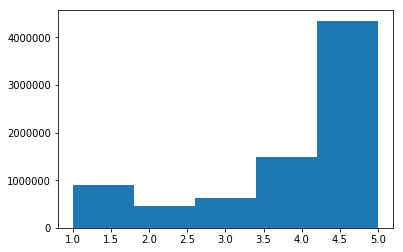

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.catplot(y="Ratings", hue="ProductId", kind="count",
#            palette="pastel", edgecolor=".6",
#           data=df);
plt.hist(df['Ratings'], bins = 5)

2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [33]:
df_usergroup = df.groupby(['UserId']).size().sort_values(ascending=False).reset_index(name='Ratingcounts')

In [34]:
df_usergroup.head()

,UserId,Ratingcounts
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406


In [168]:
userCount = df['UserId'].value_counts()
userCount.shape
df_new = df[df['UserId'].isin(userCount[userCount>=50].index)]
df_new.head()

,UserId,ProductId,Ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [169]:
df_new.shape

(125871, 3)

3. Build Popularity Recommender model.

In [175]:
pd.DataFrame(df_new.groupby('ProductId')['Ratings'].mean().head())  

,Ratings
ProductId,
0594451647,5.000000
0594481813,3.000000
0970407998,2.500000
0972683275,4.750000
1400501466,3.333333


In [176]:
# Get the popular products based on mean rating
TopProduct = df_new.groupby(['ProductId'])['Ratings'].mean().reset_index(name='TopRating')
TopProduct.sort_values('TopRating', ascending=False).head(20)

,ProductId,TopRating
0,0594451647,5.0
26017,B003RRY9RS,5.0
26013,B003RR95Q8,5.0
26009,B003RIPMZU,5.0
26006,B003RFRNYQ,5.0
26005,B003RFHFJE,5.0
26003,B003RF6H66,5.0
26002,B003RDN2V6,5.0
25999,B003RCI4OW,5.0
25998,B003RCEAB8,5.0


In [177]:
# Now we will be taking only 5 ratings products
TopRating_df =  df_new[df_new['Ratings'] == 5]

In [178]:
Product_reco = TopRating_df.groupby(['ProductId']).size().reset_index(name='Counts')

In [179]:
Product_reco.sort_values(by=['Counts'], ascending=False, inplace=True)

In [190]:
Product_reco['Rating_Rank'] = Product_reco['Counts'].rank(ascending= 0)
Product_reco.head(20)

,ProductId,Counts,Rating_Rank
16529,B003ES5ZUU,165,1.0
25695,B007WTAJTO,135,2.0
7277,B000N99BBC,134,3.0
26212,B0088CJT4U,91,4.0
25947,B00829TIEK,87,5.0
15070,B002WE6D44,85,6.0
10268,B0019EHU8G,84,7.0
14978,B002V88HFE,82,8.5
19259,B004CLYEDC,82,8.5
25943,B00829THK0,81,10.0


In [191]:
df_grouped = df_new.groupby(['UserId']).agg({'ProductId': 'count'}).reset_index()
grouped_sum = df_grouped['ProductId'].sum()
df_grouped['Ratings']  = df_grouped['ProductId'].div(grouped_sum)*100
df_grouped.sort_values(['ProductId', 'UserId'], ascending = [0,1])

,UserId,ProductId,Ratings
1203,A5JLAU2ARJ0BO,520,0.413121
1287,ADLVFFE4VBT8,501,0.398027
1086,A3OXHLG6DIBRW8,498,0.395643
1210,A6FIAB28IS79,431,0.342414
1209,A680RUE1FDO8B,406,0.322552
264,A1ODOGXEYECQQ8,380,0.301896
903,A36K2N527TXXJN,314,0.249462
521,A2AY4YUOX2N1BQ,311,0.247078
1508,AWPODHOB4GFWL,308,0.244695
462,A25C2M3QF9G7OQ,296,0.235161


4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)¶

In [181]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))

In [183]:
data = Dataset.load_from_df(df_new[['UserId', 'ProductId', 'Ratings']], reader)

In [184]:
data

In [185]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=2)

In [186]:
type(trainset)

surprise.trainset.Trainset

In [194]:
user_records = trainset.ur
type(user_records)

collections.defaultdict

5. Build Collaborative Filtering model

In [188]:
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import Prediction

In [192]:
testset_new = trainset.build_anti_testset()

In [193]:
len(testset_new)

59006311

In [195]:
from surprise import SVD
from surprise import accuracy

In [196]:
svd_model = SVD(n_factors=50,biased=False)
svd_model.fit(trainset)

In [206]:
test_pred = svd_model.test(testset)

MemoryError: 

In [198]:
test_pred_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in test_pred])

In [199]:
test_pred_df.head()

,0,1,2
0,A1CST2WUA32GP0,B000HLZXH2,1.741361
1,A6FIAB28IS79,B0040KN00S,4.261301
2,A27ADCSD15F3GL,B00B4OCWE8,2.855803
3,A200DY76VXVGP9,B002VR6A9K,3.067634
4,A2QRXQPHDMFCQV,B0011FQUQG,1.280588


In [200]:
test_pred_df.columns = ["UserId","ProductId","Ratings"]
test_pred_df.sort_values(by = ["UserId", "ProductId"],ascending=False,inplace=True)

In [201]:
test_pred_df.head()

,UserId,ProductId,Ratings
13565,AZOK5STV85FBJ,B00BF6HVG4,1.000000
5717,AZOK5STV85FBJ,B009TL1YMY,1.000000
30560,AZOK5STV85FBJ,B0092YMZJY,1.000000
16738,AZOK5STV85FBJ,B006MPRFJQ,1.000000
20339,AZOK5STV85FBJ,B003LYKLCO,2.227205


In [202]:
top_10_recos = test_pred_df.groupby("UserId").head(10).reset_index(drop=True)

In [203]:
top_10_recos.head(30)

,UserId,ProductId,Ratings
0,AZOK5STV85FBJ,B00BF6HVG4,1.000000
1,AZOK5STV85FBJ,B009TL1YMY,1.000000
2,AZOK5STV85FBJ,B0092YMZJY,1.000000
3,AZOK5STV85FBJ,B006MPRFJQ,1.000000
4,AZOK5STV85FBJ,B003LYKLCO,2.227205
5,AZOK5STV85FBJ,B003ES5ZSW,2.498549
6,AZOK5STV85FBJ,B000UGT5GO,4.261301
7,AZOK5STV85FBJ,B000QSJWO6,4.261301
8,AZOK5STV85FBJ,B000HWVOFQ,1.000000
9,AZOK5STV85FBJ,B000CSOJ2K,4.261301


In [204]:
accuracy.rmse(test_pred)

RMSE: 2.1097


2.109666439406536

8. Summarise your insights.
To get the top product recommendation based on ratings we used 2 different apporach - popularity based and collaborative filtering. Popularity based recommendation is purely based on rating received by each product, it is non personalized by nature means it is common across all user. Wheres Collaborative filtering we used item item collaboration approach where recommendation is based on similarity of ratings of product. This is personalized in nature as we recommended 5 different products for each user.